# Calibration Procedure

<i>this version uses `calibration_sweep.h5` files. </i>


* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $n_o$: effective central pixels (averaged over a couple measurement)
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



# How to use this version:

1) specify equipment parameters.

2) measure the effective central pixels and note them in this note book. (--> `n0`)

3) take a `calibration_sweep` where a known peak sweeps through 'all' pixels on ccd. Verify that the algorithm detects the peaks, pick peaks (with `ii,seed_peak`) to isolate it and associate an isolated peak with the known (`actual_wl`) wavelength.

In [1]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

%matplotlib inline

In [2]:
def wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma, curvature):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - (n0+offset_adjust*wl_center)

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta))) + curvature*n**2

In [3]:
from scipy.optimize import least_squares

def fit_residual(
                # optimization parameters
                opt_params, #  (f, delta, gamma, curvature)
                # other params and data
                px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, 
                wl_actual
                ):
    
    (f, delta, gamma, curvature) = opt_params
    wl_model = wl_p_calib_p2(px, n0, offset_adjust, wl_center, m_order, d_grating, x_pixel, f, delta, gamma,curvature)
    return (wl_model - wl_actual)

In [4]:
import h5py
import peakutils
from peakutils.plot import plot as pplot

def get_dispersion_data(ii, seed_peak,wl_actual, wl_centers,
                      peak_indexes, dispersion_data=[None]):
    
    #include seed peak
    if None in dispersion_data:
        dispersion_data = []
        dispersion_data.append([wl_actual, wl_centers[ii], seed_peak])
        
    #include the rest recursivly
    if ii+1 < len(peak_indexes):
        neighbour_peaks = peak_indexes[ii+1]
        nearest_neighbour_peak = neighbour_peaks[ (np.abs(neighbour_peaks-seed_peak)).argmin() ]
        dispersion_data.append([wl_actual, wl_centers[ii+1], nearest_neighbour_peak])
        dispersion_data = get_dispersion_data(ii+1, nearest_neighbour_peak, 
                          wl_actual, wl_centers,
                          peak_indexes, dispersion_data)
        
        return dispersion_data
    else:
        return np.array(dispersion_data)

# equipement specific params

In [5]:
x_pixel = 20e3 #nm pixel_width
f = 300e6
offset_adjust = 0

# grating_1 (1, '1800 g/mm BLZ=  500NM ')

## center wls and grating

In [6]:
d_grating = 1e6/1800 #nm /groove
wl_center_data = [670.5, 671]
n0 = np.mean(wl_center_data)

## dispersion data

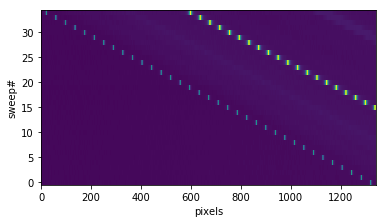

In [7]:
h5_file=h5py.File('grating_1_data/181211_172037_picam_calibration_sweep.h5')
center_wls=h5_file['measurement/picam_calibration_sweep/center_wls'].value
spectra=h5_file['measurement/picam_calibration_sweep/spectra'].value
h5_file.close()

plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(20)

plt.ylabel('sweep#')
plt.xlabel('pixels')

### find peaks

0 [1319]
15 [ 747 1335]


(0, 1340)

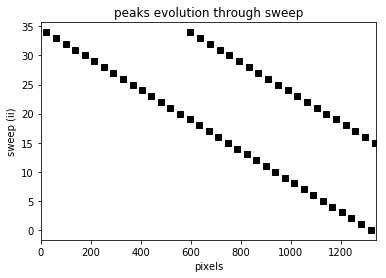

In [8]:
plot_spectra = False
peak_indexes = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 20)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
    
    if plot_spectra and ii%10:
        plt.figure()
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure()
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    if len(peak) != Npeak:
        print(ii,peak)
        Npeak = len(peak)
plt.title('peaks evolution through sweep')
plt.ylabel('sweep (ii)')
plt.xlabel('pixels')
plt.xlim(0,1340)

### track individual peaks and associate with actual wavelengths

(0, 1340)

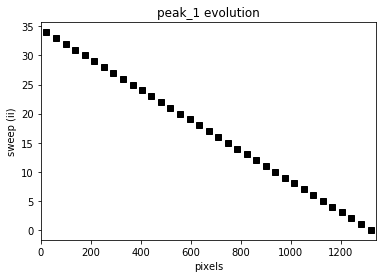

In [9]:
#peak_1 at 532nm
ii, seed_peak,wl_actual = 0,1319,532
dispersion_data_1 = get_dispersion_data(ii, seed_peak,wl_actual, center_wls, peak_indexes)


plt.figure()
for peak in dispersion_data_1[:,2]:
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    ii +=1    
plt.title('peak_1 evolution')
plt.ylabel('sweep (ii)')
plt.xlabel('pixels')
plt.xlim(0,1340)    

In [10]:
dispersion_data = np.concatenate([dispersion_data_1]) 
initial_guess = (f,-0.1,0.5,0)

kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
print(initial_guess - result.x)
print(result.message, result.nfev)



res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = offset_adjust,
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ res_dict[x] for x in Y ]))

[  0.00000000e+00   5.74496143e-02  -6.10489214e-03   1.37137264e-07]
`xtol` termination condition is satisfied. 41
[300000000.0, -0.15744961432207136, 0.50610489214060039, 670.75, 0, 555.5555555555555, 20000.0, -1.3713726383063457e-07]


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arcsin
  


# grating_2 (2, '600 g/mm BLZ=  750NM ')

using laser line at 532nm

In [11]:
d_grating = 1e6/600 #nm /groove
wl_center_data = [670, 670]

n0 = np.mean(wl_center_data)

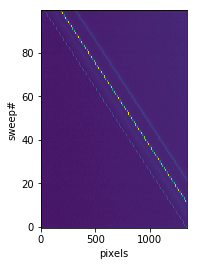

In [12]:
h5_file=h5py.File('grating_2_data/181212_121128_picam_calibration_sweep.h5')
center_wls=h5_file['measurement/picam_calibration_sweep/center_wls'].value
spectra=h5_file['measurement/picam_calibration_sweep/spectra'].value
h5_file.close()

plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(20)
plt.ylabel('sweep#')
plt.xlabel('pixels')

0 [1325]


(0, 1340)

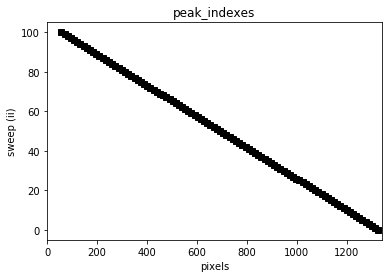

In [21]:
plot_spectra = False
peak_indexes = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 20)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
    
    
    if plot_spectra and ii%10:
        plt.figure()
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure()
plt.title('peak_indexes')
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    if len(peak) != Npeak:
        print(ii,peak)
        Npeak = len(peak)
plt.ylabel('sweep (ii)')
plt.xlabel('pixels')
plt.xlim(0,1340)

(0, 1340)

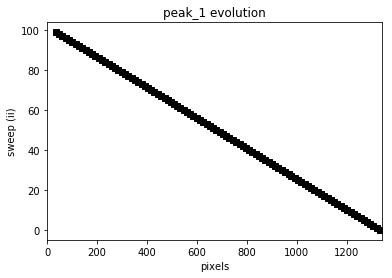

In [14]:
#peak_1 at 532nm
ii, seed_peak,wl_actual = 0, 1332, 532
dispersion_data_1 = get_dispersion_data(ii, seed_peak,wl_actual, center_wls, peak_indexes)

plt.figure()
for peak in dispersion_data_1[:,2]:
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    ii +=1    
plt.title('peak_1 evolution')
plt.ylabel('sweep (ii)')
plt.xlabel('pixels')
plt.xlim(0,1340)      

In [15]:
dispersion_data = np.concatenate([dispersion_data_1]) 
initial_guess = (f,0.8,0.5,0)


kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
print(initial_guess - result.x)
print(result.message, result.nfev)



res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = offset_adjust,
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ res_dict[x] for x in Y ]))

[  0.00000000e+00   8.79039638e-01  -1.13990389e-02   1.54895148e-07]
`xtol` termination condition is satisfied. 46
[300000000.0, -0.079039638076765562, 0.51139903889553706, 670.0, 0, 1666.6666666666667, 20000.0, -1.5489514755695404e-07]


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arcsin
  


# grating_3 (3, '300 g/mm BLZ=  500NM ')

using a raman shift at 547.12nm

In [16]:
d_grating = 1e6/300 #nm /groove
wl_center_data = [670, 670.5]
n0 = np.mean(wl_center_data)

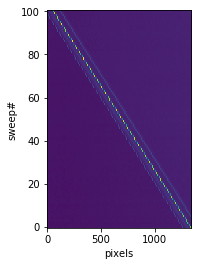

In [17]:
h5_file=h5py.File('grating_3_data/181212_125601_picam_calibration_sweep.h5')
center_wls=h5_file['measurement/picam_calibration_sweep/center_wls'].value
spectra=h5_file['measurement/picam_calibration_sweep/spectra'].value
h5_file.close()

plt.imshow(np.log10(spectra), origin='lower')
plt.gca().set_aspect(20)
plt.ylabel('sweep#')
plt.xlabel('pixels')

C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0 [1325]


(0, 1340)

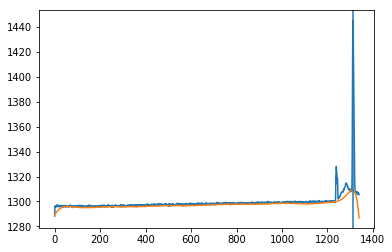

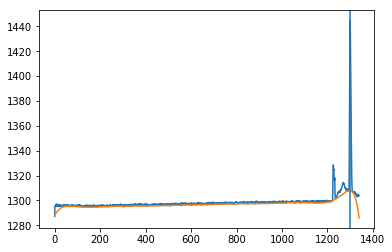

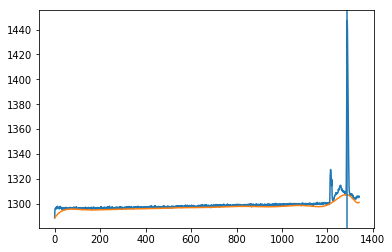

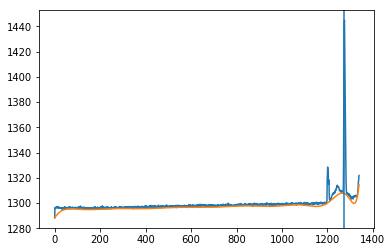

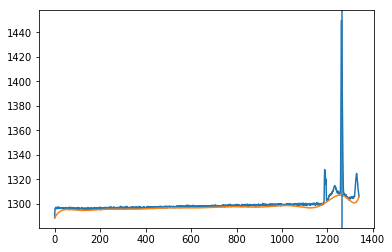

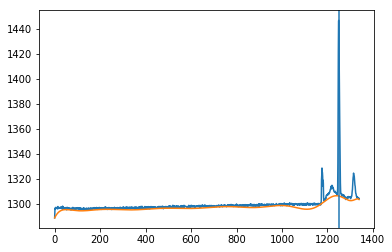

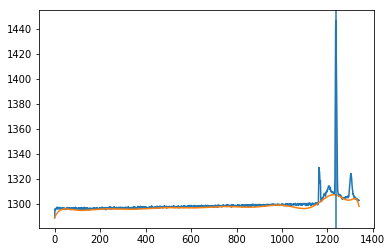

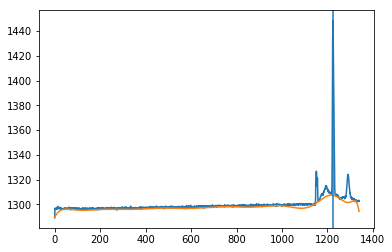

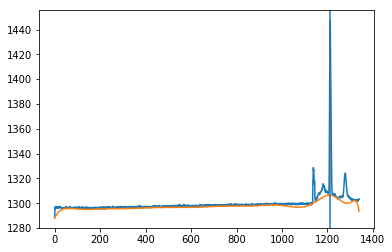

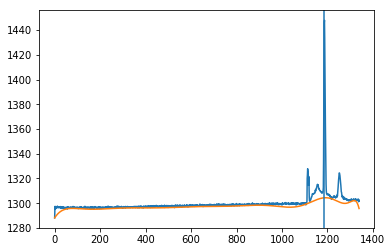

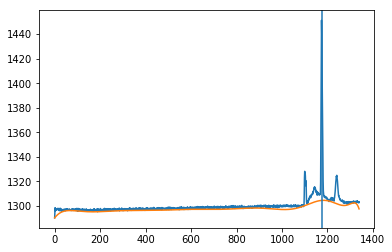

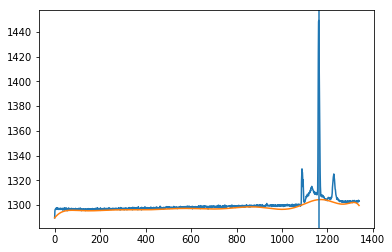

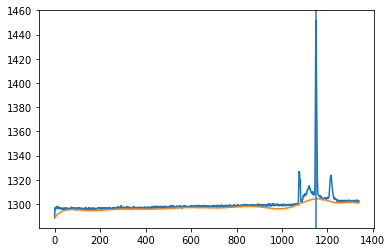

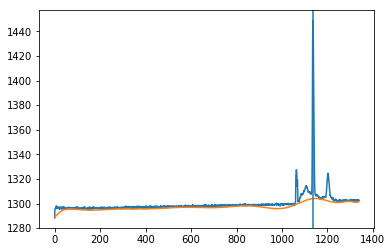

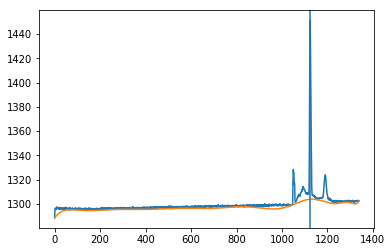

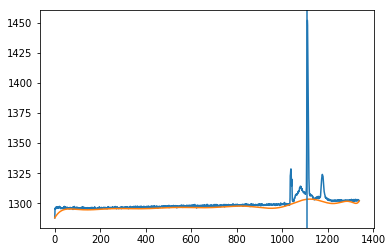

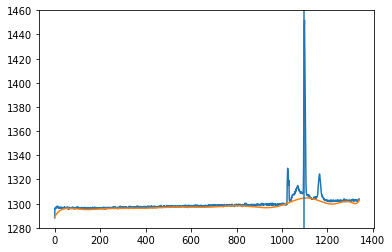

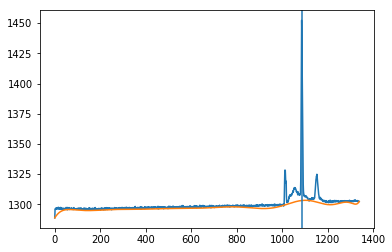

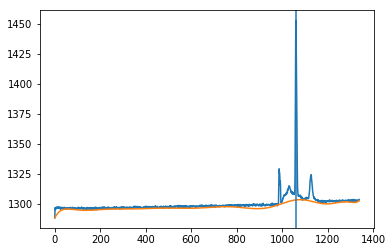

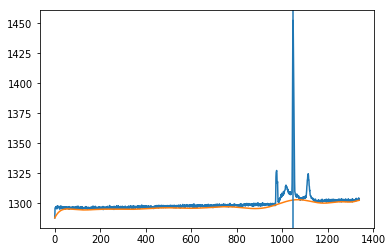

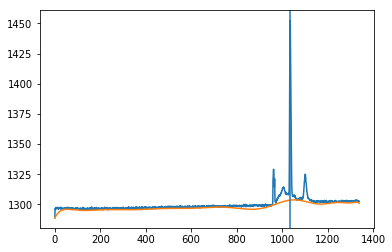

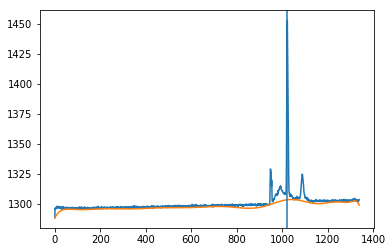

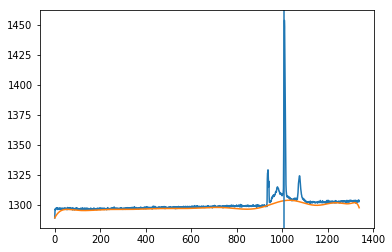

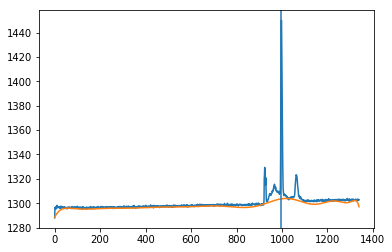

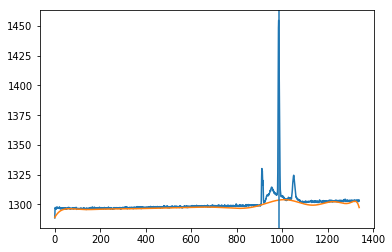

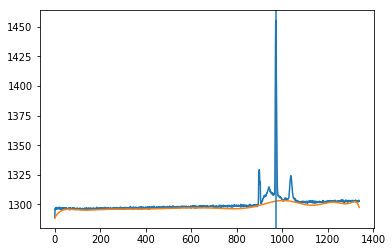

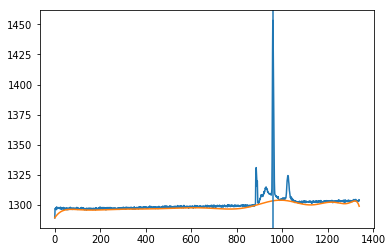

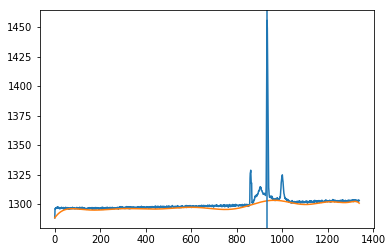

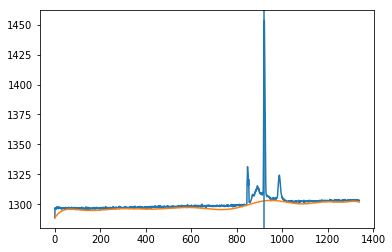

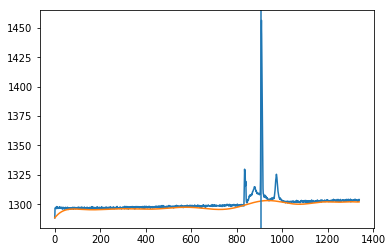

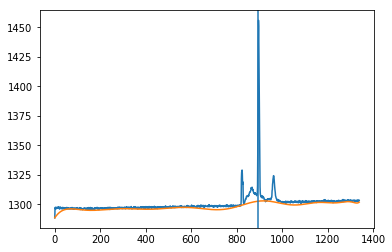

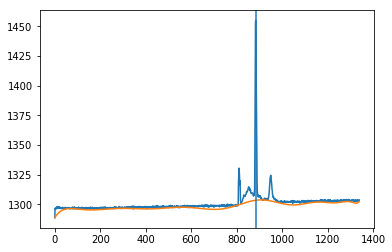

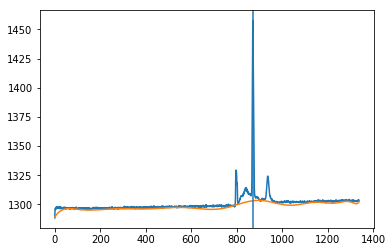

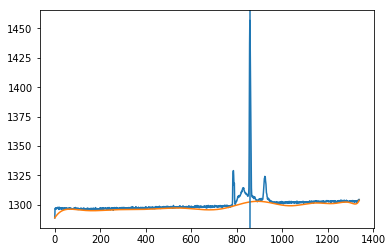

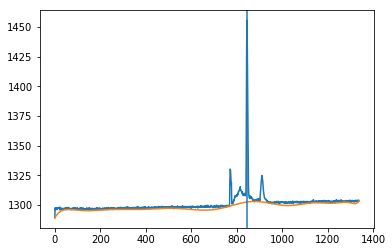

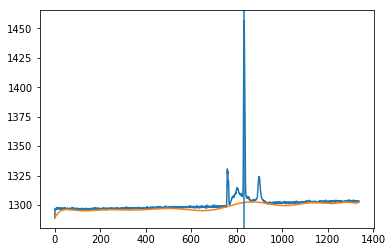

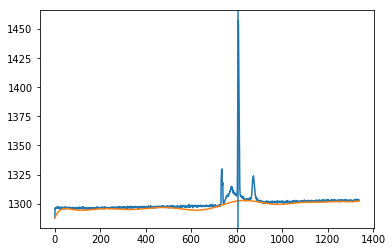

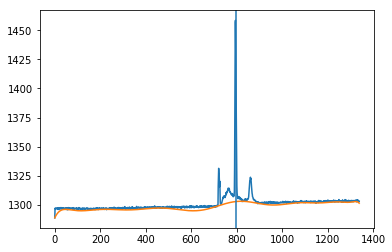

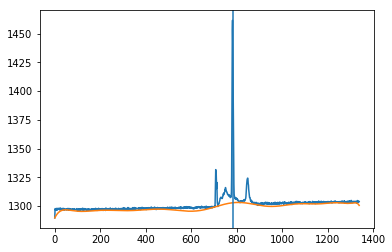

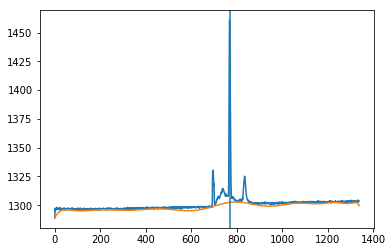

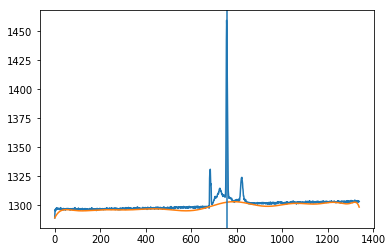

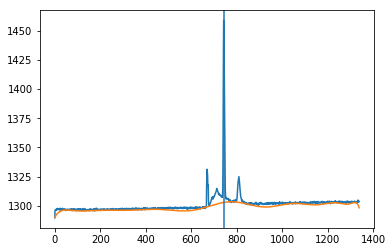

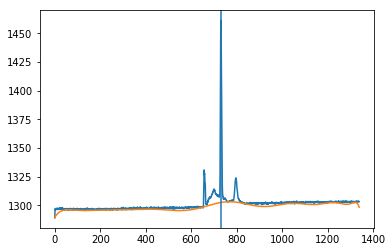

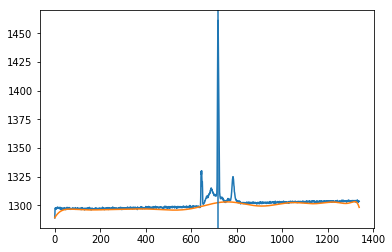

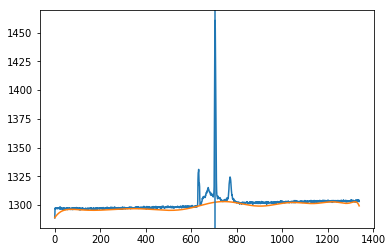

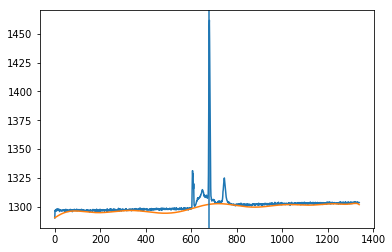

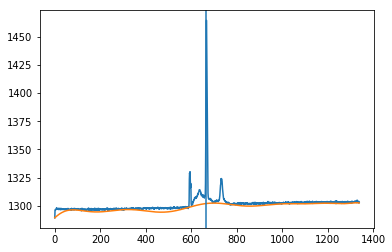

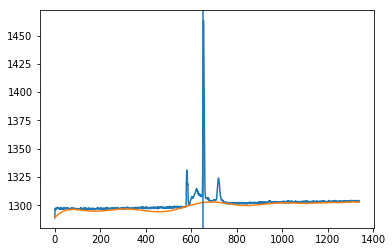

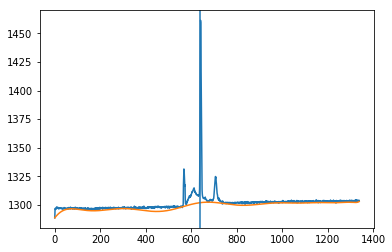

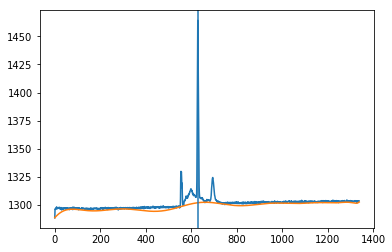

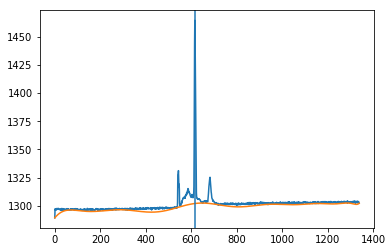

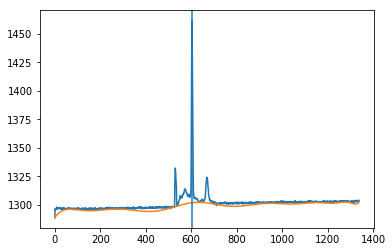

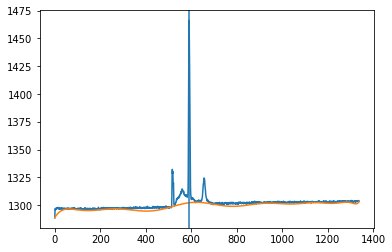

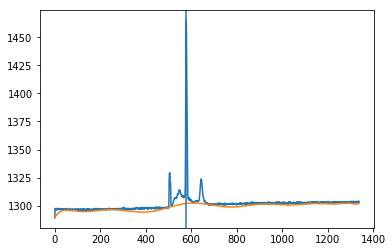

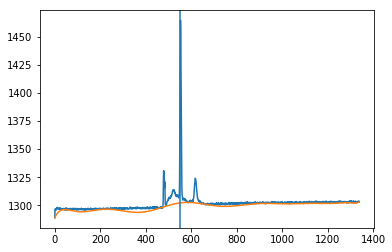

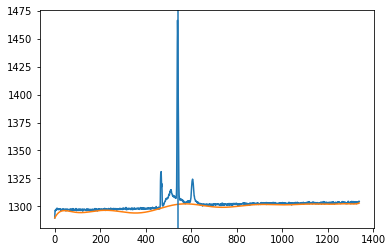

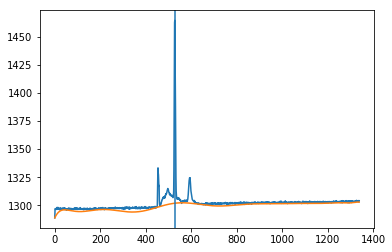

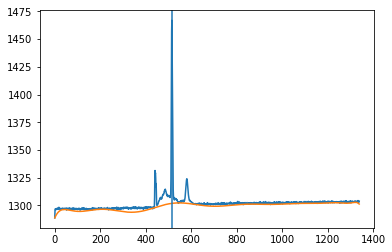

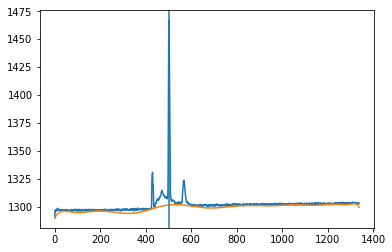

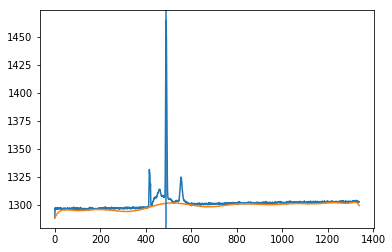

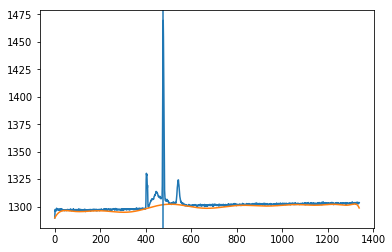

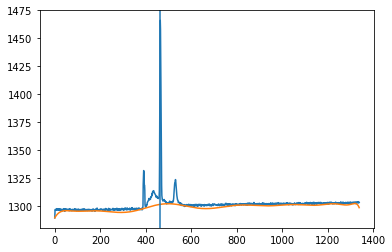

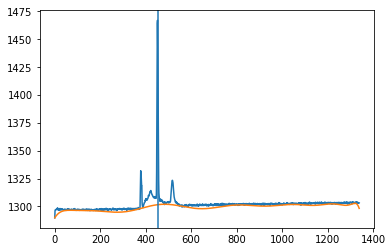

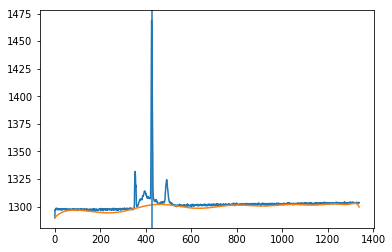

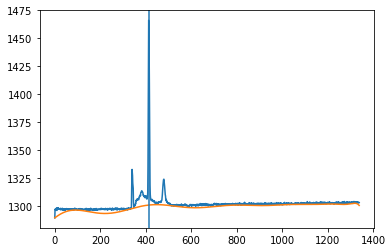

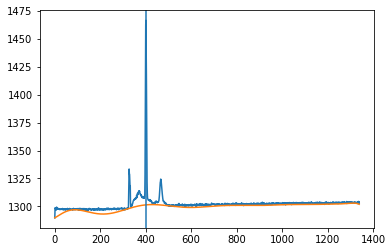

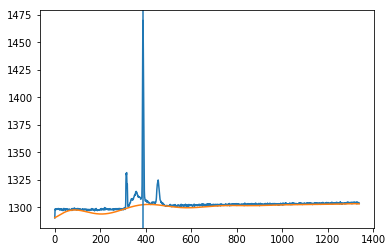

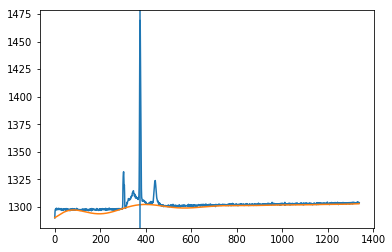

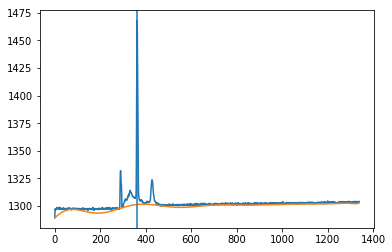

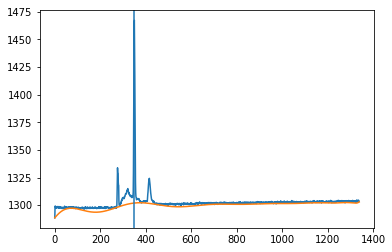

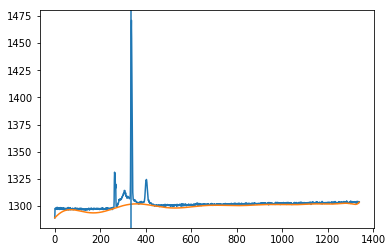

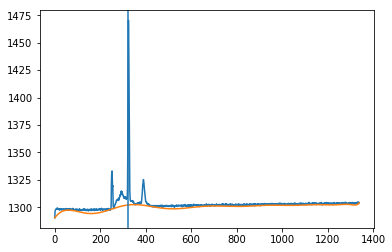

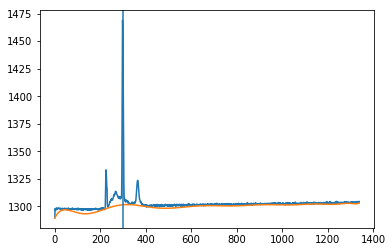

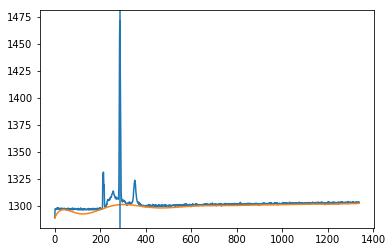

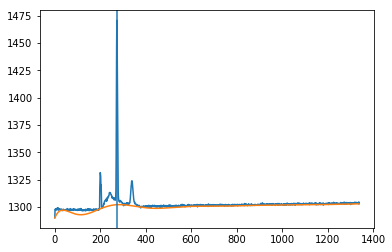

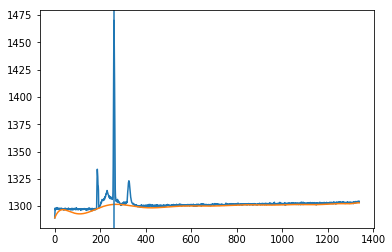

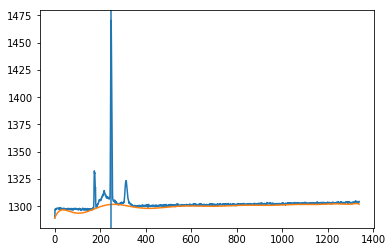

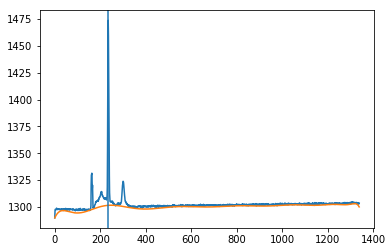

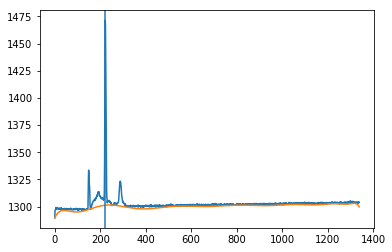

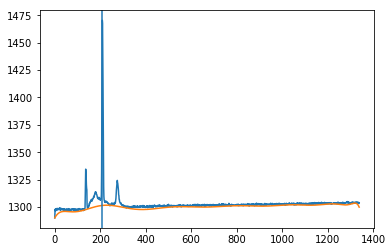

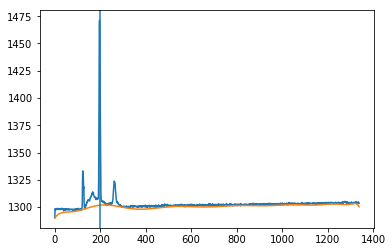

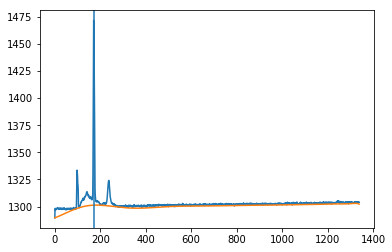

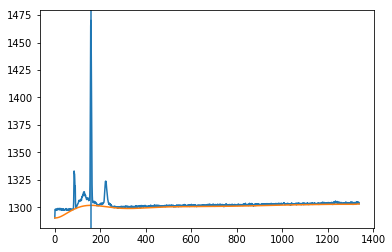

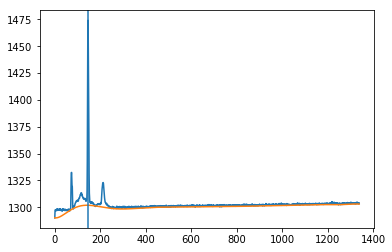

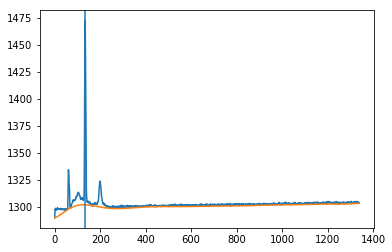

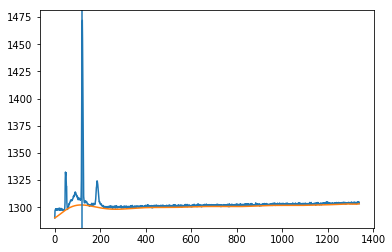

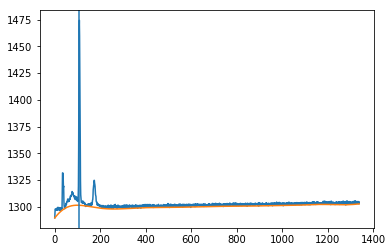

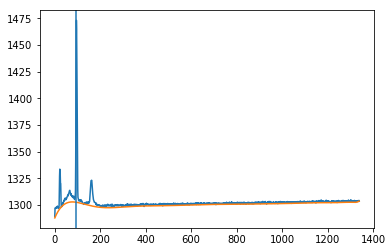

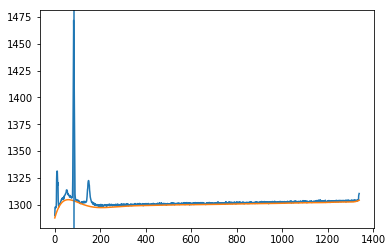

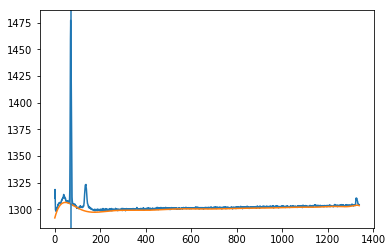

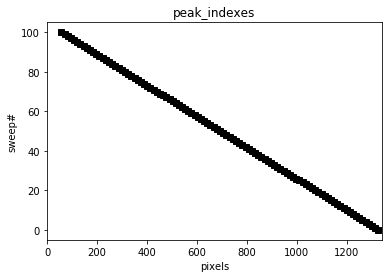

In [18]:
plot_spectra = True
peak_indexes = []

for ii,z in enumerate(spectra):
    base = peakutils.baseline(z, 20)
    indexes = peakutils.indexes(z-base, thres=0.15, min_dist=75)
    peak_indexes.append(indexes)
    
    
    if plot_spectra and ii%10:
        plt.figure()
        plt.plot(z)
        plt.plot(base)
        for idx in indexes:
            plt.axvline(idx)

Npeak = 0
plt.figure()
plt.title('peak_indexes')
for ii,peak in enumerate(peak_indexes):
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    if len(peak) != Npeak:
        print(ii,peak)
        Npeak = len(peak)
plt.ylabel('sweep#')
plt.xlabel('pixels')
plt.xlim(0,1340)

(0, 1340)

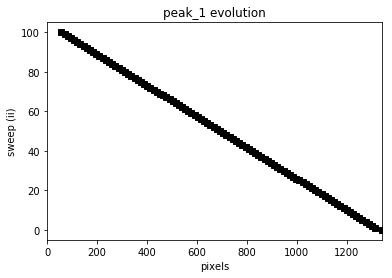

In [19]:
#peak_1 at 547.2
ii, seed_peak, wl_actual = 0, 1340, 547.2 #seed sweep#, .., ..
dispersion_data_1 = get_dispersion_data(ii, seed_peak, wl_actual, center_wls, peak_indexes)

plt.figure()
for peak in dispersion_data_1[:,2]:
    plt.plot(peak,np.ones_like(peak)*ii,'ks')
    ii +=1    
plt.title('peak_1 evolution')
plt.ylabel('sweep (ii)')
plt.xlabel('pixels')
plt.xlim(0,1340)    

In [20]:
dispersion_data = np.concatenate([dispersion_data_1]) 
initial_guess = (f,0.1,-0.2,0)

kwargs = dict(
    wl_actual=dispersion_data[:,0], # nm
    wl_center=dispersion_data[:,1], # nm
    px=dispersion_data[:,2], 
    
    n0 = n0,
    m_order=1,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    offset_adjust = offset_adjust,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs, xtol=1e-15, ftol=1e-15)
print(initial_guess - result.x)
print(result.message, result.nfev)



res_dict = dict(    
    n0=n0,
    d_grating=d_grating, # nm
    x_pixel=x_pixel, #nm
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    offset_adjust = offset_adjust,
    curvature = result.x[3]
)


# insert to .ini file
# f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature
Y = 'f, delta, gamma, n0, offset_adjust, d_grating, x_pixel, curvature'.split(', ')
print(str([ res_dict[x] for x in Y ]))

[  0.00000000e+00   1.30129112e-01  -7.27795698e-01  -1.24379335e-07]
`xtol` termination condition is satisfied. 89
[300000000.0, -0.030129112395956135, 0.52779569786686165, 670.25, 0, 3333.3333333333335, 20000.0, 1.2437933464513057e-07]
